# dqm.ipynb
This notebook generates DUNE DQM (data quality monitoring) plots. 

## Introduction

First connect to a Jupyter machine where DUNE cvmfs is available e.g. <https://analytics-hub.fnal.gov>, open a terminal and and follow the [instructions](https://github.com/dladams/duneproc#readme) to install *dunerun*.
Here we assume the package is installed at ~/proc/install/common/dunerun but any location is fine.  

Copy this noteboook dunerun.ipynb from the installation area to a directory of your choosing and open the copy on Jupyter.
Since you are reading this, you may have already done so.  

Run the *dunerun* setup (change the location to match your installation) and import dunerun and other packages of interest:

In [1]:
pysup_dunerun = '~/proc/install/common/dunerun/python/setup.py'
%run {pysup_dunerun}
import sys
import os
import glob
import dunerun
print(f"dunerun version is {dunerun.version()}")
rel = 'v09_46_00_00:e20:prof'
dsw = None

dunerun version is 1.1.2


## VOMS proxy

We need a VOMS proxy, to access DUNE data. The following block obtains one, if needed.

In [2]:
proxy = dunerun.DuneProxy(nopassword_kinit=False, tmin=600)
proxy.check_proxy(lev=0)
print(f"Proxy time remaining is {proxy.time()} sec")

Proxy time remaining is 32699 sec


## DUNE release shell

We construct a shell with the *dunesw* release where we want to run the DQM job. Run a few commands to check it is OK.

In [3]:
if dsw is None: dsw = dunerun.DuneRun('dunesw', rel, shell=True)
line = '-----------------------------------------------------------'
print(line)
for com in ['date', 'this-should-fail', 'duneHelp', 'echo DUNE_INSTALL_DIR=$DUNE_INSTALL_DIR']:
    dsw.run(com)
    print(line)

-----------------------------------------------------------


Setting up dunesw v09_46_00_00 e20:prof


Fri Mar 18 18:26:43 UTC 2022
-----------------------------------------------------------


/bin/bash: line 7: this-should-fail: command not found


-----------------------------------------------------------
Welcome to dunetpc 
Some available commands:
              duneHelp - Display information about the current setup of dunetpc.
                   lar - Run the art/larsoft event looop e.g. to process event data.
  product_sizes_dumper - Display the products and size in an event data file.
               fcldump - Display the resolved configuration for a fcl file.
               liblist - List available plugin libraries.
        pdChannelRange - Display protoDUNE channel grops and ranges.
           duneRunData - Display run data for a run.
           duneTestFcl - Test some high-level fcl configurations.
Use option "-h" with any of these for more information.
-----------------------------------------------------------
DUNE_INSTALL_DIR=
-----------------------------------------------------------


## *duneproc*

The package *duneproc* provides the fcl files need used here. To install that package, follow the instruction in [duneproc tutorial01](https://github.com/dladams/duneproc/blob/master/doc/tutorial01.md) and set insdir below to point to that installation area.

If the installation directory does not exist, the following block will install the package there. Note that in this example, we do the installation (and building and cloning) in the local ./install directory.


In [4]:
reldir = rel.replace(':', '-')     # Colon in file names wil confuse paths
insdir = f"./install/{reldir}/duneproc"
sup_duneproc = f"{insdir}/setup.sh"

if not os.path.exists(sup_duneproc):
    blddir = f"./install/build/{reldir}/duneproc"
    gitdir = f"./install/build/repos/duneproc"
    for dir in [insdir, blddir]:
        print(f"Creating {dir}")
        if not os.path.exists(dir): os.makedirs(dir)
    precoms = [f"export DUNE_INSTALL_DIR={insdir}", f"export DUNE_BUILD_DIR=./build", f"export DUNE_INSTALL_BYPKG=false"]
    dbu = dunerun.DuneRun('dunebuild', rel, precoms=precoms, shell=True, dbg=4)
    print(line)
    if not os.path.exists(f"{gitdir}"):
        print(">>>>> Cloning...")
        dbu.run(f"git clone https://github.com/dladams/duneproc {gitdir}")
        print(line)
    print(">>>>> Building...")
    dbu.run(f"{gitdir}/build")
    print(line)
    dbu.run(f"ls -ls {insdir}")
    
if not os.path.exists(sup_duneproc):
    raise Exception(f"Setup for dunerun not found at {sup_duneproc}")
!ls -ls {insdir}

Creating ./install/v09_46_00_00-e20-prof/duneproc
Creating ./install/build/v09_46_00_00-e20-prof/duneproc
DuneRun: Using package setup file /home/dladams/proc/install/common/dunerun/setup.sh
DuneRun: Using setup file /home/dladams/proc/install/common/dunerun/bin/setup-dunebuild.sh
-----------------------------------------------------------
>>>>> Building...
DuneRun::run: Executing command export DUNE_INSTALL_DIR=./install/v09_46_00_00-e20-prof/duneproc
DuneRun::run: Executing command export DUNE_BUILD_DIR=./build
DuneRun::run: Executing command export DUNE_INSTALL_BYPKG=false
DuneRun::run: Executing command source /home/dladams/proc/install/common/dunerun/setup.sh
DuneRun::run: Executing command source /home/dladams/proc/install/common/dunerun/bin/setup-dunebuild.sh v09_46_00_00:e20:prof


Setting up dunesw v09_46_00_00 e20:prof


DuneRun::run: Executing command ./install/build/repos/duneproc/build


Source: /home/dladams/proc/pkgs/duneproc/ipynb/install/build/repos/duneproc
Build: ./build/duneproc
Install: ./install/v09_46_00_00-e20-prof/duneproc

Running cmake in /home/dladams/proc/pkgs/duneproc/ipynb/install/build/repos/duneproc...
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /cvmfs/larsoft.opensciencegrid.org/products/gcc/v9_3_0/Linux64bit+3.10-2.17/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /cvmfs/larsoft.opensciencegrid.org/products/gcc/v9_3_0/Linux64bit+3.10-2.17/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done


      CMAKE_CXX_COMPILER: /cvmfs/larsoft.opensciencegrid.org/products/gcc/v9_3_0/Linux64bit+3.10-2.17/bin/c++
 CMAKE_CXX_COMPILE_FLAGS: 
         CMAKE_CXX_FLAGS: -std=c++17
Start building dictionaries


-- Configuring done
-- Generating done
-- Build files have been written to: /home/dladams/proc/pkgs/duneproc/ipynb/build/duneproc

Building...
[  8%] Generating duneproc.cxx, duneprocDict.rootmap
[ 16%] Building CXX object Utility/CMakeFiles/duneproc.dir/IcebergHelper.cxx.o
[ 25%] Building CXX object Utility/CMakeFiles/duneproc.dir/duneproc.cxx.o
[ 33%] Linking CXX shared library libduneproc.so
[ 33%] Built target duneproc
[ 41%] Built target duneproc-dictgen
[ 50%] Building CXX object Utility/CMakeFiles/duneprocDict.dir/duneproc.cxx.o
[ 58%] Linking CXX shared library libduneprocDict.so
[ 66%] Built target duneprocDict
[ 75%] Building CXX object Exec/CMakeFiles/ibRunPeriod.dir/ibRunPeriod.cxx.o
[ 83%] Linking CXX executable ibRunPeriod
[ 83%] Built target ibRunPeriod
[ 91%] Building CXX object Exec/CMakeFiles/ibRunPeriodRuns.dir/ibRunPeriodRuns.cxx.o
[100%] Linking CXX executable ibRunPeriodRuns
[100%] Built target ibRunPeriodRuns

Installing...
Consolidate compiler generated dependen

./install/build/repos/duneproc/build: line 125: cd: ./build/duneproc: No such file or directory


[ 33%] Built target duneproc
[ 41%] Built target duneproc-dictgen
Consolidate compiler generated dependencies of target duneprocDict
[ 66%] Built target duneprocDict
Consolidate compiler generated dependencies of target ibRunPeriod
[ 83%] Built target ibRunPeriod
Consolidate compiler generated dependencies of target ibRunPeriodRuns
[100%] Built target ibRunPeriodRuns
Install the project...
-- Install configuration: ""
-- Installing: /home/dladams/proc/pkgs/duneproc/ipynb/install/v09_46_00_00-e20-prof/duneproc/bin/duneprocHelp
-- Installing: /home/dladams/proc/pkgs/duneproc/ipynb/install/v09_46_00_00-e20-prof/duneproc/bin/duneproc
-- Installing: /home/dladams/proc/pkgs/duneproc/ipynb/install/v09_46_00_00-e20-prof/duneproc/bin/getGridProxy
-- Installing: /home/dladams/proc/pkgs/duneproc/ipynb/install/v09_46_00_00-e20-prof/duneproc/bin/formatInt
-- Installing: /home/dladams/proc/pkgs/duneproc/ipynb/install/v09_46_00_00-e20-prof/duneproc/bin/runjobs
-- Installing: /home/dladams/proc/pkgs/d

Now add this setup to our environment. The *duneproc* fcl files are now accessible. To verify this, we look for *run_dataprep.fcl*.

In [5]:
dsw.run('fcldump run_dataprep.fcl 1')
print(line)
dsw.run(f"source {sup_duneproc}")
print(line)
dsw.run('fcldump run_dataprep.fcl 1')

fcldump: ERROR: Unable to find file run_dataprep.fcl
fcldump: Search path:
  .
  ./job
  /cvmfs/dune.opensciencegrid.org/products/dune/dunesw/v09_46_00_00/fcl
  /cvmfs/dune.opensciencegrid.org/products/dune/protoduneana/v09_46_00_00/job
  /cvmfs/larsoft.opensciencegrid.org/products/geant4reweight/v01_13_00/fcl
  /cvmfs/dune.opensciencegrid.org/products/dune/duneprototypes/v09_46_00_00/fcl
  /cvmfs/dune.opensciencegrid.org/products/dune/dunesim/v09_46_00_00/fcl
  /cvmfs/dune.opensciencegrid.org/products/dune/dunecalib/v09_46_00_00/fcl
  /cvmfs/dune.opensciencegrid.org/products/dune/dunedataprep/v09_46_00_00/fcl
  /cvmfs/dune.opensciencegrid.org/products/dune/duneana/v09_46_00_00/fcl
  /cvmfs/dune.opensciencegrid.org/products/dune/dunereco/v09_46_00_00/fcl
  /cvmfs/dune.opensciencegrid.org/products/dune/duneopdet/v09_46_00_00/fcl
  /cvmfs/dune.opensciencegrid.org/products/dune/dunecore/v09_46_00_00/fcl
  /cvmfs/larsoft.opensciencegrid.org/products/nusystematics/v01_00_11/fcl
  /cvmfs/lar

## Processing event data

Next we try processing some event data following the examples in [duneproc tutorial01](https://github.com/dladams/duneproc/blob/master/doc/tutorial01.md) using the file we found in [dunerun dunedata notebook](https://github.com/dladams/dunerun/blob/master/ipynb/dunedata.ipynb).

In [6]:
furl = 'root://fndca1.fnal.gov:1094/pnfs/fnal.gov/usr/dune/tape_backed/dunepro/protodune/np04/beam/detector/None/raw/06/68/39/48/np04_raw_run005240_0001_dl1.root'
if not os.path.exists('job01'):
    furl = 'root://fndca1.fnal.gov:1094/pnfs/fnal.gov/usr/dune/tape_backed/dunepro/protodune/np04/beam/detector/None/raw/06/68/39/48/np04_raw_run005240_0001_dl1.root'
    for com in ['mkdir job01', 'cd job01', f"lar -c run_dataprep.fcl -n 1 -s {furl}", 'cd ..']:
        print(f"\n>>>>>>>>>> Running {com} <<<<<<<<<<")
        dsw.run(com)

Much ado about nothing. When we scroll through the above, we see that TPC data was read in in for each of the six APAs but no tools were run.  

Next we run a DQM job on the same event.

In [7]:
for com in ['rm -rf job02', 'mkdir job02', 'cd job02', f"lar -c dqm.fcl -n 1 -s {furl}", 'cd ..']:
    print(f"\n>>>>>>>>>> Running {com} <<<<<<<<<<")
    dsw.run(com)


>>>>>>>>>> Running rm -rf job02 <<<<<<<<<<

>>>>>>>>>> Running mkdir job02 <<<<<<<<<<

>>>>>>>>>> Running cd job02 <<<<<<<<<<

>>>>>>>>>> Running lar -c dqm.fcl -n 1 -s root://fndca1.fnal.gov:1094/pnfs/fnal.gov/usr/dune/tape_backed/dunepro/protodune/np04/beam/detector/None/raw/06/68/39/48/np04_raw_run005240_0001_dl1.root <<<<<<<<<<
%MSG-i MF_INIT_OK:  Early 18-Mar-2022 18:27:22 UTC JobSetup
Messagelogger initialization complete.
%MSG


Warning in <TGeoManager>: Changing system of units to ROOT units (cm, s, GeV).
Info in <TGeoManager::Import>: Reading geometry from file: /cvmfs/dune.opensciencegrid.org/products/dune/dunecore/v09_46_00_00/gdml/protodune_v7.gdml
Info in <TGeoManager::TGeoManager>: Geometry GDMLImport, Geometry imported from GDML created
Info in <TGeoManager::SetTopVolume>: Top volume is volWorld. Master volume is volWorld
Info in <TGeoNavigator::BuildCache>: --- Maximum geometry depth set to 100
Info in <TGeoManager::CheckGeometry>: Fixing runtime shapes...
Info in <TGeoManager::CheckGeometry>: ...Nothing to fix
Info in <TGeoManager::CloseGeometry>: Counting nodes...
Info in <TGeoManager::Voxelize>: Voxelizing...
Info in <TGeoManager::CloseGeometry>: Building cache...
Info in <TGeoManager::CountLevels>: max level = 5, max placements = 1148
Info in <TGeoManager::CloseGeometry>: 36176 nodes/ 5435 volume UID's in Geometry imported from GDML
Info in <TGeoManager::CloseGeometry>: ----------------modeler rea

%MSG-i GeometryCore:  Early 18-Mar-2022 18:27:46 UTC JobSetup
New detector geometry loaded from 
	/cvmfs/dune.opensciencegrid.org/products/dune/dunecore/v09_46_00_00/gdml/protodune_v7.gdml
	/cvmfs/dune.opensciencegrid.org/products/dune/dunecore/v09_46_00_00/gdml/protodune_v7_nowires.gdml

%MSG
%MSG-i GeometryCore:  Early 18-Mar-2022 18:27:46 UTC JobSetup
Sorting volumes...
%MSG
%MSG-i DuneApaChannelMapAlg:  Early 18-Mar-2022 18:27:46 UTC JobSetup
Initializing channel map...
%MSG
Cryostat 0:
  15360 total channels
  6 APAs
  For all identical APA:
    Number of channels per APA = 2560
    U channels per APA = 800
    V channels per APA = 800
    Z channels per APA = 960
    Pitch in U Plane = 0.4669
    Pitch in V Plane = 0.4669
    Pitch in Z Plane = 0.4792
GeoApaChannelGroupService::ctor: Group 0 (apa0) has 2560 channels from 4/4 readout planes.
GeoApaChannelGroupService::ctor: Group 1 (apa1) has 2560 channels from 4/4 readout planes.
GeoApaChannelGroupService::ctor: Group 2 (apa2) ha

Warning in <TFile::Append>: Replacing existing TH1: FieldResponse_U (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: FieldResponse_V (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: FieldResponse_Y (Potential memory leak).


DataPrepByApaModule::reconfigure:              LogLevel: 2
DataPrepByApaModule::reconfigure:           DecoderTool: pdsp_decoder
DataPrepByApaModule::reconfigure:   OutputTimeStampName: dataprep
DataPrepByApaModule::reconfigure:       OutputDigitName: 
DataPrepByApaModule::reconfigure:        OutputWireName: 
DataPrepByApaModule::reconfigure:         ChannelGroups: [apas]
DataPrepByApaModule::reconfigure:        BeamEventLabel: beamevent
DataPrepByApaModule::reconfigure:  OnlineChannelMapTool: pd_onlineChannelMapByFemb
DataPrepByApaModule::reconfigure:          KeepChannels: []
DataPrepByApaModule::reconfigure:          SkipChannels: []
DataPrepByApaModule::reconfigure:     SkipEmptyChannels: true
DataPrepByApaModule::reconfigure:        DeltaTickCount: 0.005
DataPrepByApaModule::reconfigure:      ApaChannelCounts: [2560]
PdspOnlineChannel::ctor:   LogLevel: 1
PdspOnlineChannel::ctor:   Ordering: FEMB
DataPrepByApaModule::reconfigure: The following APAs will be processed.
DataPrepByApa

[Fri Mar 18 18:27:54 2022] perform_with_timeout: Warning: CA verification is off. URL='https://ifb-data.fnal.gov:8104/ifbeam/data/data?b=DUNE_CERN_SEP2018&t0=1539358500.000&t1=1539358680.000&f=csv'
[Fri Mar 18 18:27:56 2022] perform_with_timeout: Warning: CA verification is off. URL='https://ifb-data.fnal.gov:8104/ifbeam/data/data?b=DUNE_CERN_SEP2018_TIMBER&t0=1539358500.000&t1=1539358680.000&f=csv'


DataPrepByApaModule::produce: Run 5240-1, event 7, nproc=0
DataPrepByApaModule::produce: Real data event time: 1539358525 (2018-10-12 15:35:25 UTC)
DataPrepByApaModule::produce: Timing clock: 76967926275177357
DataPrepByApaModule::produce: Trigger flag: 12 (Beam)
DataPrepByApaModule::produce: Beam event does not have a TOF match.
DataPrepByApaModule::produce: Beam momenta: 1.05096
TpcToolBasedRawDigitPrepService:beginEvent: Begin processing run 5240-1 event 7 with 10 tools.
AdcEventViewer::beginEvent: Begin processing event 7 for run 5240-1
DataPrepByApaModule::produce: Fetching digits and clocks for APA 1.
DataPrepByApaModule::produce:   APA 1 digit count from tool: 2560
DataPrepByApaModule::produce:   APA 1 stats count from tool: 1
DataPrepByApaModule::produce:   APA 1 clock count from tool: 2560
DataPrepByApaModule::produce: Raw data read status: 2
DataPrepByApaModule::produce: Channel clocks for APA 1 are consistent with an offset of 7.3787e+17 ticks.
DataPrepByApaModule::produce: 

List the files in the run directory, we see a lot of image files including four for each of the six APAs:

In [8]:
!ls -ls job02

total 118891
  624 -rw-r--r--. 1 dladams fnalgrid   638388 Mar 18 18:28 adcraw_tpp0c_run005240_evt000007.png
  970 -rw-r--r--. 1 dladams fnalgrid   993279 Mar 18 18:28 adcraw_tpp0u_run005240_evt000007.png
  963 -rw-r--r--. 1 dladams fnalgrid   985754 Mar 18 18:28 adcraw_tpp0v_run005240_evt000007.png
  633 -rw-r--r--. 1 dladams fnalgrid   648080 Mar 18 18:28 adcraw_tpp0z_run005240_evt000007.png
  626 -rw-r--r--. 1 dladams fnalgrid   640976 Mar 18 18:28 adcraw_tpp1c_run005240_evt000007.png
  990 -rw-r--r--. 1 dladams fnalgrid  1013660 Mar 18 18:28 adcraw_tpp1u_run005240_evt000007.png
  965 -rw-r--r--. 1 dladams fnalgrid   987384 Mar 18 18:28 adcraw_tpp1v_run005240_evt000007.png
  639 -rw-r--r--. 1 dladams fnalgrid   653801 Mar 18 18:28 adcraw_tpp1z_run005240_evt000007.png
  625 -rw-r--r--. 1 dladams fnalgrid   639641 Mar 18 18:28 adcraw_tpp2c_run005240_evt000007.png
  975 -rw-r--r--. 1 dladams fnalgrid   997921 Mar 18 18:28 adcraw_tpp2u_run005240_evt000007.png
  968 -rw-r--r--. 1 dladams

Let's display one of these:

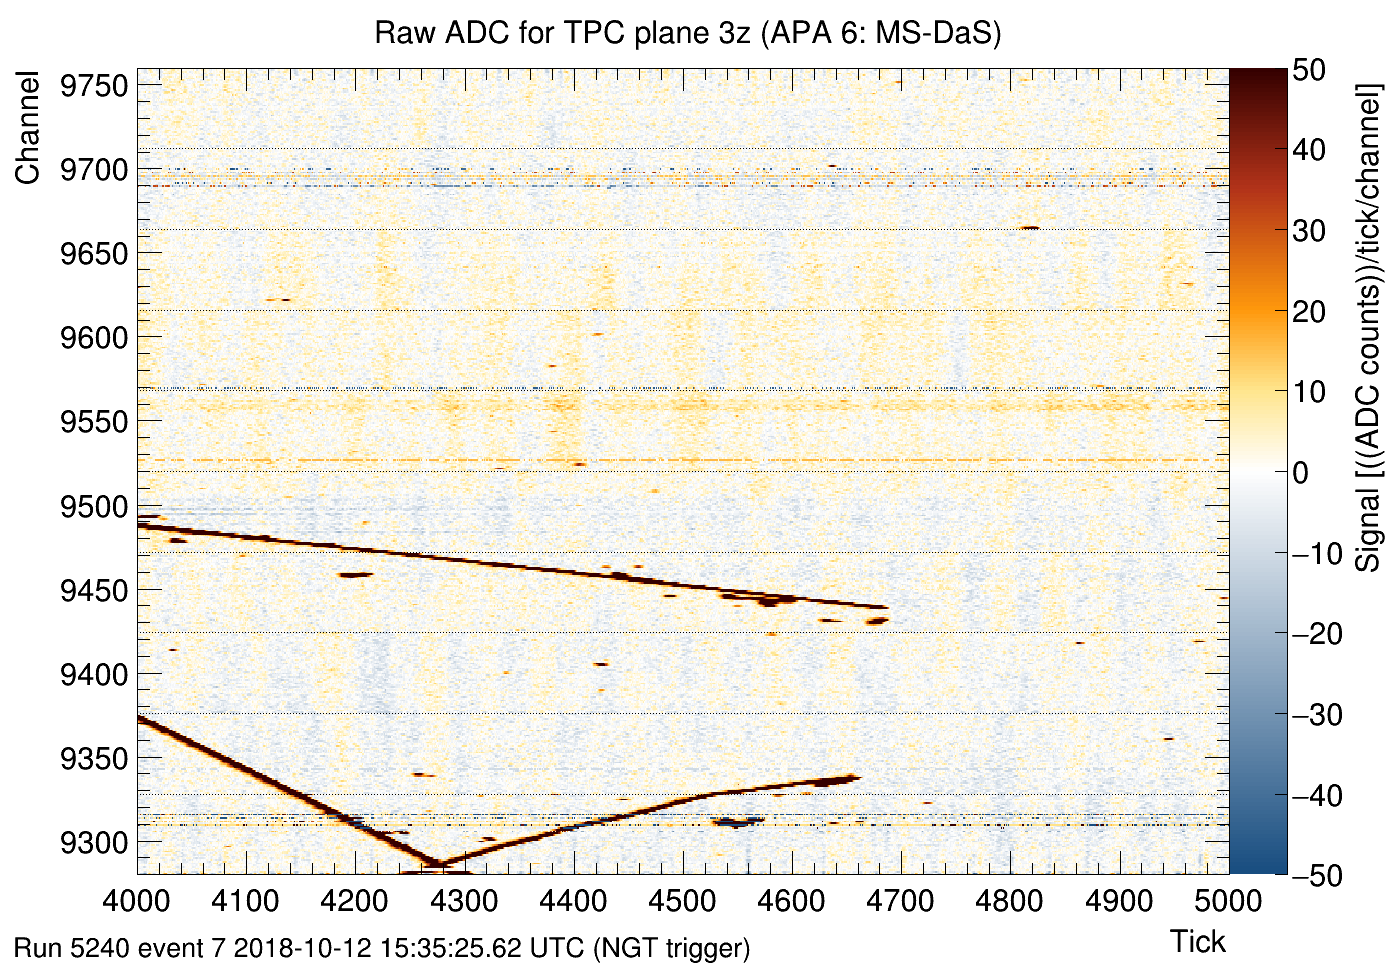

In [9]:
from IPython.display import Image
display(Image(filename='job02/adcraw_tpp3z_run005240_evt000007.png'))

We stop execution here to render a notebook that is not to large to store in git.  

Remove the following block or comment out the exception and rerun to generate all plots. Or just execute the block(s) of interest.

In [10]:
raise Exception('Waiting for user input')

Exception: Waiting for user input

In [ ]:
# Show event displays.
fnams = glob.glob('./job02/adcraw_tpp*.png')
fnams.sort()
for fnam in fnams:
    print(fnam)
    display(Image(filename=fnam))

In [ ]:
# Show noise vs. channel.
fnams = glob.glob('./job02/chmet_pednoise*.png')
fnams.sort()
for fnam in fnams:
    print(fnam)
    display(Image(filename=fnam))

In [ ]:
# Show pedestal vs. channel.
fnams = glob.glob('./job02/chmet_ped_*.png')
fnams.sort()
for fnam in fnams:
    print(fnam)
    display(Image(filename=fnam))

In [ ]:
# Show full detector display
display(Image('job02/detraw-run005240-evt000007-coll.png'))

In [ ]:
dsw.run('lar -h')

In [ ]:
help(dsw)